In [12]:
using PyCall
println(PyCall.python)

/Users/miyata/spin-system-simulations/.venv/bin/python


In [13]:
include("IsingCore.jl")
using .IsingCore
using StochasticAD
using CairoMakie
using Optimisers
using LinearAlgebra
using Statistics: mean, std

println(names(IsingCore))

# hyper parameters
T0 = [5.0]
N = 12 # size of the lattice, N x N

function optimize(θ0; move=IsingCore.independent_sampler, is_move=false, η=0.01, n=200, n_batch=1)
    optimizer = Adam(η)
    θ = deepcopy(θ0)
    θ_trace = [θ]
    setup = Optimisers.setup(optimizer, θ)
    for i in 1:n
        samples = [derivative_estimate(T -> obj(T; move, is_move), θ[1]) for _ in 1:n_batch]
        g = mean(samples)
        s = std(samples)
        setup, θ = Optimisers.update(setup, θ, g)
        push!(θ_trace, deepcopy(θ))
        if i % 10 == 0
            println("Iteration $i: mean = $g, std = $s, T = $(θ[1])")
        end
    end
    return θ_trace
end

function obj(T; move=IsingCore.independent_sampler, is_move=false)
    config = IsingCore.initial_state(N)
    if is_move
        -IsingCore.ising_model_remc(N, T, config, move)[3]
    else
        -IsingCore.ising_model(N, T, config, move)[3]
    end
end

[:IsingCore, :calc_energy, :calc_mag, :independent_sampler, :initial_state, :ising_model, :ising_model_manyT, :ising_model_remc, :metropolis_sampler]


obj (generic function with 3 methods)

In [14]:
θ_trace_re = optimize(T0; is_move=true, η=0.01, n=300, n_batch=50)
obj_trace_re = [-obj(θ[1]; is_move=true) for θ in θ_trace_re]
println("finish to optimize replica exchange.")

Iteration 10: mean = 7.196361880215719, std = 3.4173496775260577, T = 4.900086325695596
Iteration 20: mean = 7.772939421184297, std = 3.235458228899417, T = 4.798484788014402
Iteration 30: mean = 8.170606589409447, std = 4.144893853604338, T = 4.6945403276126045
Iteration 40: mean = 9.004417705588075, std = 4.620831198392257, T = 4.587471652352967
Iteration 50: mean = 10.941388209114189, std = 6.0657053851055815, T = 4.475835139385578
Iteration 60: mean = 11.073227682304237, std = 5.681313965918688, T = 4.36062921372352
Iteration 70: mean = 13.465832713203568, std = 7.526815961566389, T = 4.243332192359837
Iteration 80: mean = 16.856698576448704, std = 9.123861906331488, T = 4.120983771023212
Iteration 90: mean = 11.183322377416133, std = 14.515236140523617, T = 3.989106996025595
Iteration 100: mean = 17.5587219277363, std = 15.693432756662098, T = 3.850978916576145
Iteration 110: mean = 21.576985754705237, std = 32.88070430598365, T = 3.7034686169741273
Iteration 120: mean = 34.049437

In [18]:
θ_trace = optimize(T0; η=0.01, n=300, n_batch=50)
obj_trace = [-obj(θ[1]) for θ in θ_trace]
println("finish to optimize.")

Iteration 10: mean = 6.426274619608501, std = 2.9694987922213767, T = 4.90004710952503
Iteration 20: mean = 7.972005970907989, std = 2.7280594082162084, T = 4.7995334547728215
Iteration 30: mean = 8.651439142361125, std = 2.879009699495712, T = 4.695943063856114
Iteration 40: mean = 9.333717782095533, std = 3.7100672930769574, T = 4.588250673136061
Iteration 50: mean = 9.79222537855134, std = 5.002467648741909, T = 4.47657670457534
Iteration 60: mean = 10.921840359038661, std = 6.033065096687532, T = 4.360861984762977
Iteration 70: mean = 13.377826584244207, std = 6.586750799745416, T = 4.2415120494348795
Iteration 80: mean = 13.052039088454897, std = 7.485229832892725, T = 4.114495804816814
Iteration 90: mean = 14.163120945180578, std = 9.704492705530047, T = 3.9816504984951635
Iteration 100: mean = 20.707164483971287, std = 13.133916251084544, T = 3.8414998152708053
Iteration 110: mean = 20.72228352427329, std = 25.548130792617116, T = 3.6914299040176655
Iteration 120: mean = 28.7782

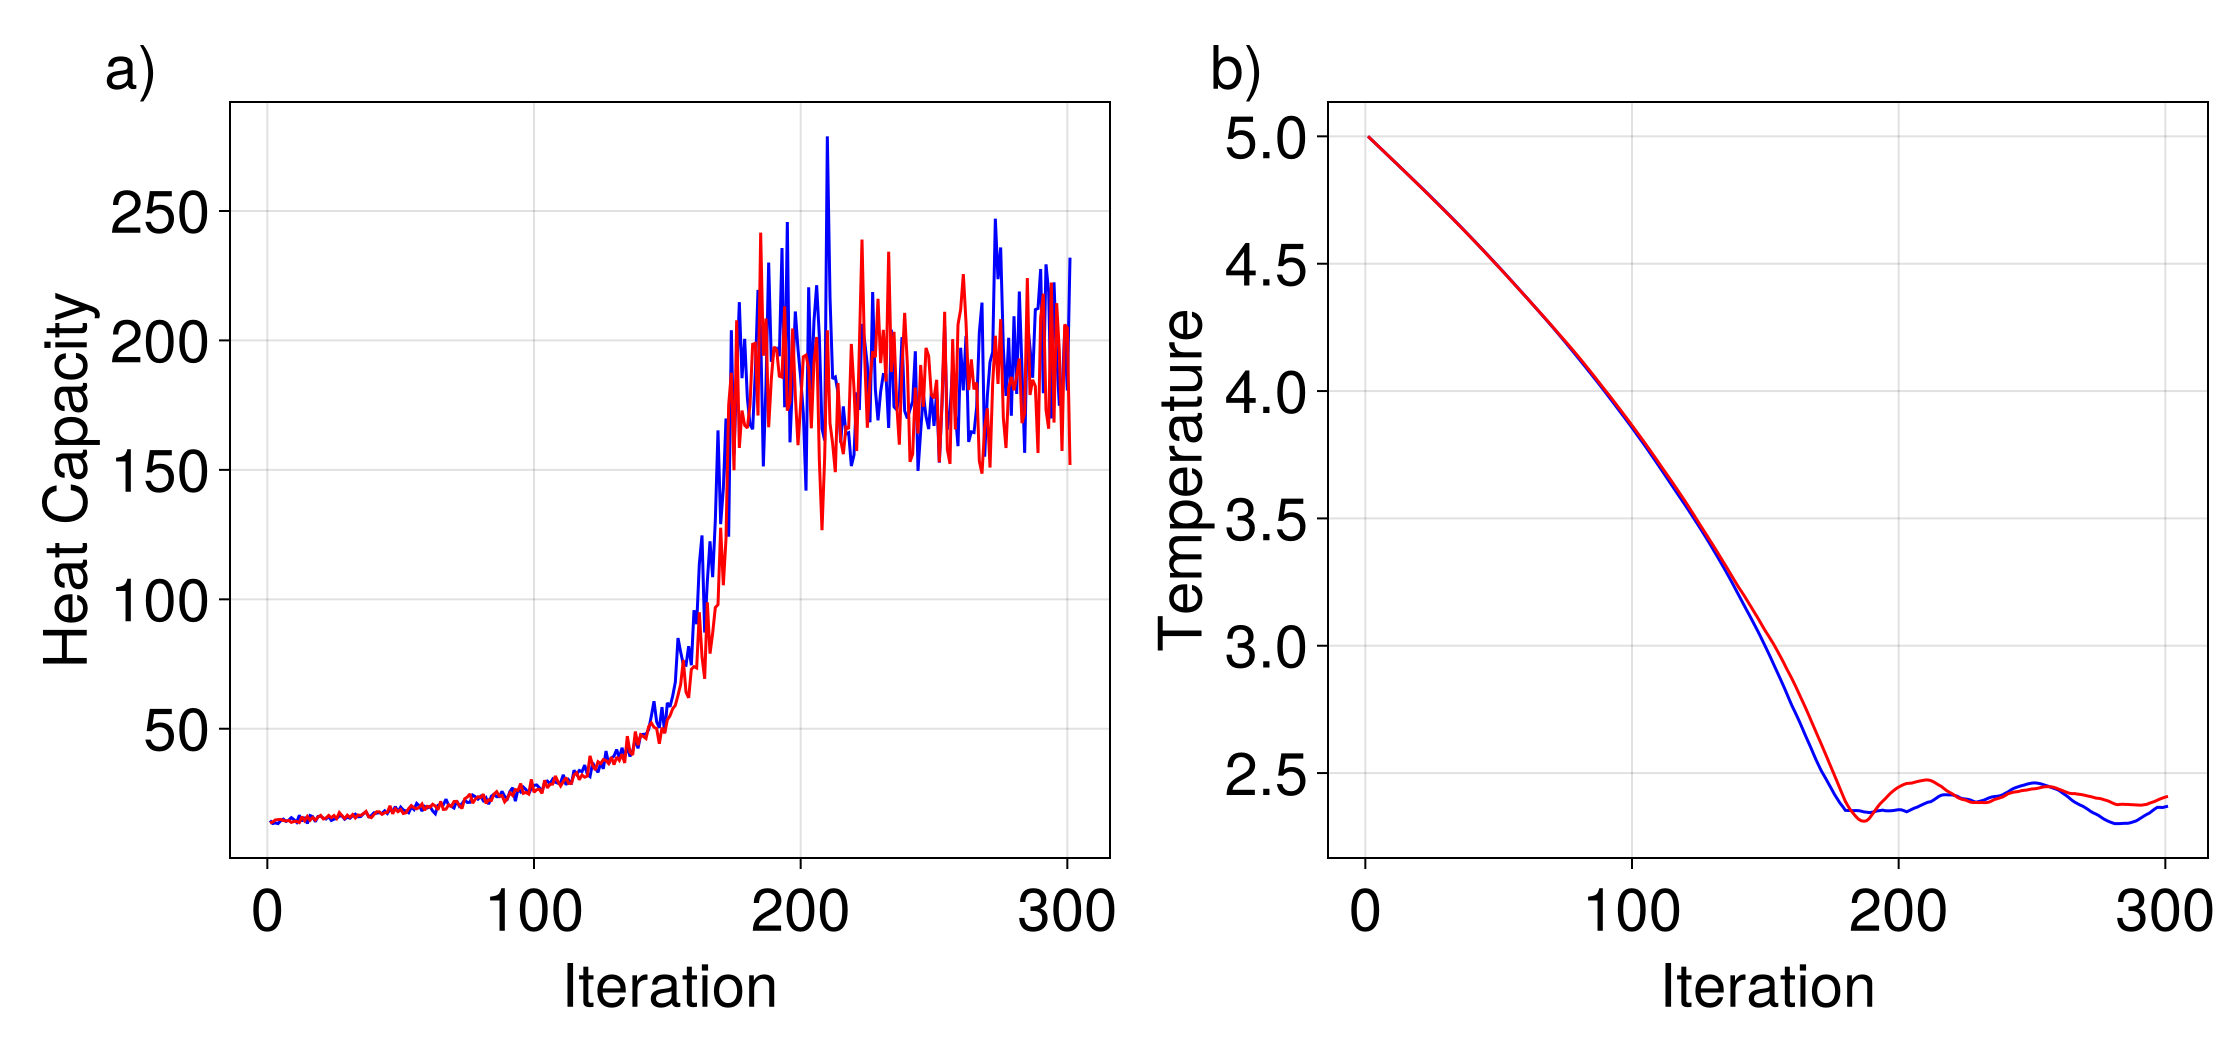

CairoMakie.Screen{IMAGE}


In [19]:
begin
    fig = Figure(size=(1120, 525), fontsize=30)
    ax1 = fig[1, 1] = Axis(fig, ylabel="Heat Capacity", xlabel="Iteration")
    ax2 = fig[1, 2] = Axis(fig, ylabel="Temperature", xlabel="Iteration")
    Label(fig[1, 1, TopLeft()], "a)")
    Label(fig[1, 2, TopLeft()], "b)")

    lines!(ax1, obj_trace, color=:blue, label="independent")
    lines!(ax1, obj_trace_re, color=:red, label="replica exchange")
    lines!(ax2, [θ[1] for θ in θ_trace], color=:blue, label="independent")
    lines!(ax2, [θ[1] for θ in θ_trace_re], color=:red, label="replica exchange")
    display(fig)
end